In [123]:
## Importing packages
# Pandas
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 5]

# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline

# RNN (Keras and Tensorflow)
import tensorflow as tf
import keras
from keras.layers import Dense,Dropout,SimpleRNN,LSTM, Activation
from keras.models import Sequential
from keras.optimizers import SGD

In [124]:
### Read csvs
data_before_2002 = pd.read_csv('PJM_Load_hourly.csv', index_col = None) # Data before 2002 for PJM
data_after_2002 = pd.read_csv('PJME_hourly.csv', index_col = None) # Data after 2002 for PJM

In [125]:
###Cleaning and organizing data

##Unifying data before and after 2002 on a dataframe
all_data = []
all_data.append(data_before_2002)
all_data.append(data_after_2002)
all_data = pd.concat(all_data, sort=True)
all_data = pd.DataFrame(all_data)
all_data.fillna(0, inplace=True)
all_data['Consumption MW'] = all_data['PJME_MW'] + all_data['PJM_Load_MW']
all_data = all_data.sort_values(by='Datetime')
all_data = all_data.reset_index(drop=True)

##Splitting the date (Year, Month and Day) and time (Hours and Minutes)
all_data['Original'] = all_data['Datetime']
all_data['Split'] = all_data['Datetime'].str.split('-')
all_data[['Year', 'Month', 'Day and Time']] = pd.DataFrame(all_data.Split.values.tolist())
all_data['Split'] = all_data['Day and Time'].str.split(' ')
all_data[['Day', 'Full Time']] = pd.DataFrame(all_data.Split.values.tolist())
all_data['Split'] = all_data['Full Time'].str.split(':')
all_data[['Hours', 'Minutes', 'Seconds']] = pd.DataFrame(all_data.Split.values.tolist())

In [126]:
###Creating features 'Weekday', 'if it is weekend', 'if it is a holiday' 'and 'day of year'
all_data['Datetime'] = all_data['Year'] + '-' + all_data['Month'] + '-' + all_data['Day']
all_data['Datetime'] = pd.to_datetime(all_data['Datetime'])
all_data['Weekday'] = all_data['Datetime'].dt.weekday
all_data['Weekend'] = (all_data['Weekday'] >= 5).astype(int)
all_data['Holiday'] = all_data['Datetime'].isin(calendar().holidays()).astype(int)
all_data['Day of year'] = all_data['Datetime'].dt.dayofyear

###Selecting columns
all_data = all_data.drop(columns = ['PJME_MW', 'PJM_Load_MW', 'Split', 'Day and Time', 'Minutes', 'Seconds', 'Full Time']) # Seconds are ignored because they are all equal to zero
RNN_data = all_data[['Original', 'Consumption MW']] # Reserving this data for the RNN model
all_data = all_data[['Hours', 'Day', 'Month', 'Year', 'Day of year', 'Weekday', 'Weekend', 'Holiday', 'Consumption MW']]

In [127]:
###Visualizing the dataframe
all_data.head(3)

,Hours,Day,Month,Year,Day of year,Weekday,Weekend,Holiday,Consumption MW
0,01,01,04,1998,91,2,0,0,22259.0
1,02,01,04,1998,91,2,0,0,21244.0
2,03,01,04,1998,91,2,0,0,20651.0


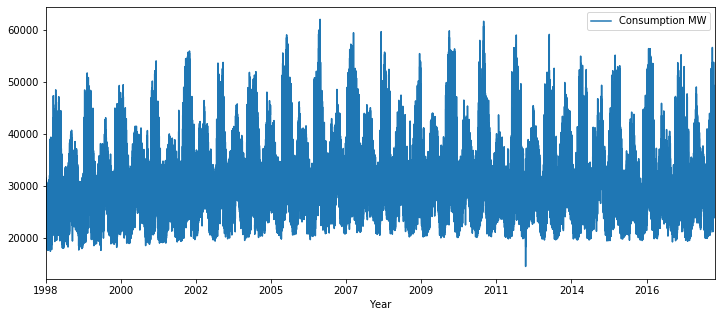

In [128]:
### Plotting all the data
## Consumption (MW) by Time
all_data.plot(x = 'Year', y = 'Consumption MW')

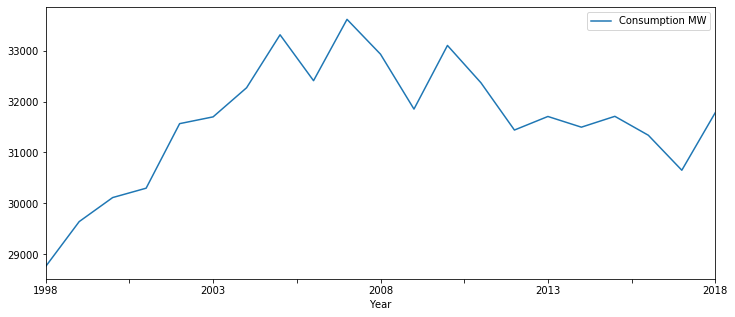

In [129]:
## Average Consumption (MW) by Year
all_data.groupby('Year', as_index=False)['Consumption MW'].mean().plot(x = 'Year', y = 'Consumption MW')

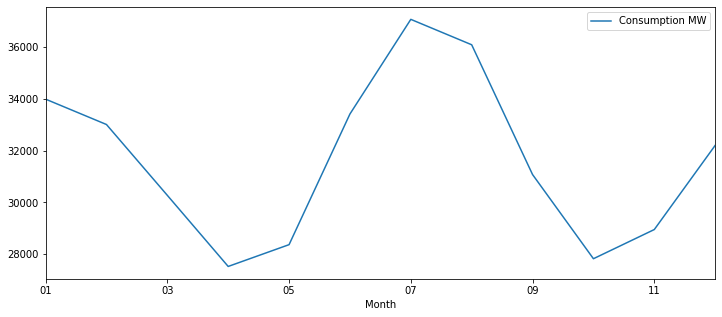

In [130]:
## Average Consumption (MW) by Month
all_data.groupby('Month', as_index=False)['Consumption MW'].mean().plot(x = 'Month', y = 'Consumption MW')

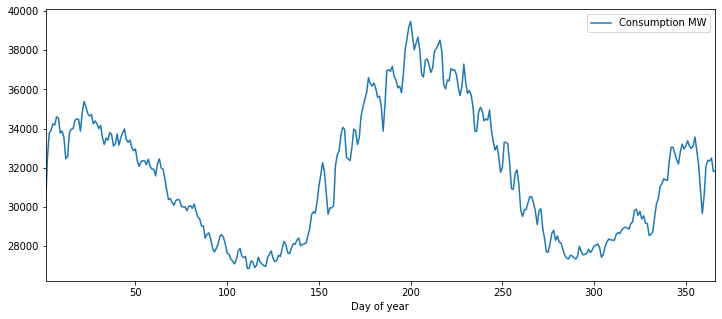

In [131]:
## Average Consumption (MW) by Day of year
all_data.groupby('Day of year', as_index=False)['Consumption MW'].mean().plot(x = 'Day of year', y = 'Consumption MW')

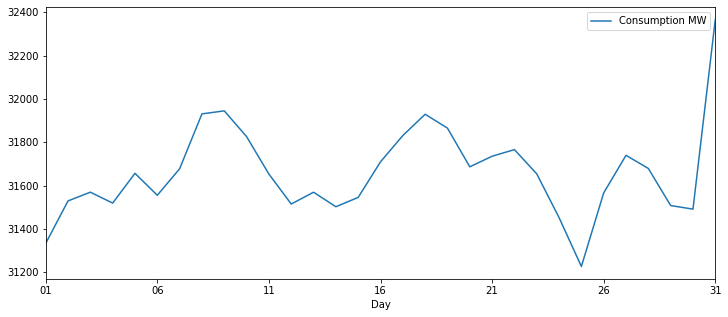

In [132]:
## Average Consumption (MW) by Day of month
all_data.groupby('Day', as_index=False)['Consumption MW'].mean().plot(x = 'Day', y = 'Consumption MW')

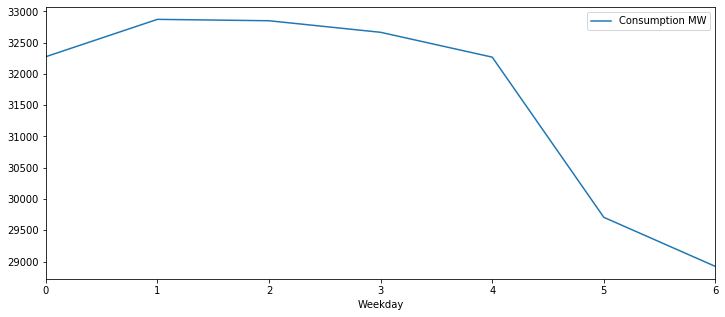

In [133]:
## Average Consumption (MW) by Day of week
all_data.groupby('Weekday', as_index=False)['Consumption MW'].mean().plot(x = 'Weekday', y = 'Consumption MW')

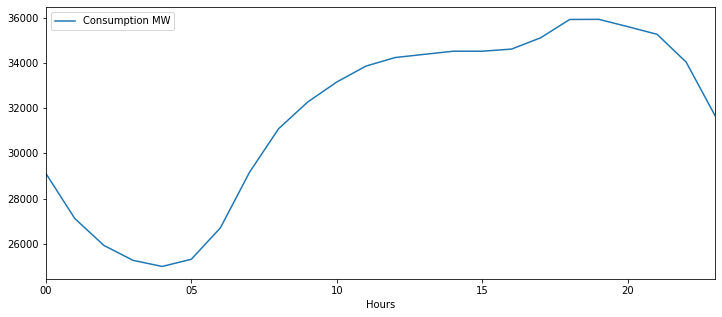

In [134]:
## Average Consumption (MW) by hour
all_data.groupby('Hours', as_index=False)['Consumption MW'].mean().plot(x = 'Hours', y = 'Consumption MW')

In [135]:
## Average Consumption (MW
all_data['Consumption MW'].mean()

31653.24111700755

,Weekend,Consumption MW
0,0,32587.953183
1,1,29314.082621


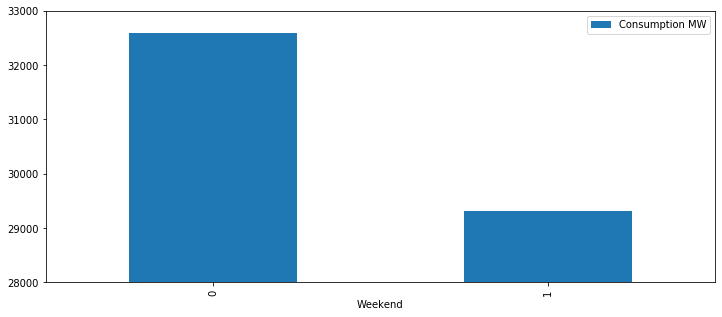

In [136]:
## Average Consumption (MW) by Weekend
#1 = Weekend, 0 = Not weekend
all_data.groupby('Weekend', as_index=False)['Consumption MW'].mean().plot(x = 'Weekend', y = 'Consumption MW', kind = 'bar')
plt.ylim(28000, 33000)

all_data.groupby('Weekend', as_index=False)['Consumption MW'].mean()

,Holiday,Consumption MW
0,0,31679.994793
1,1,30696.256394


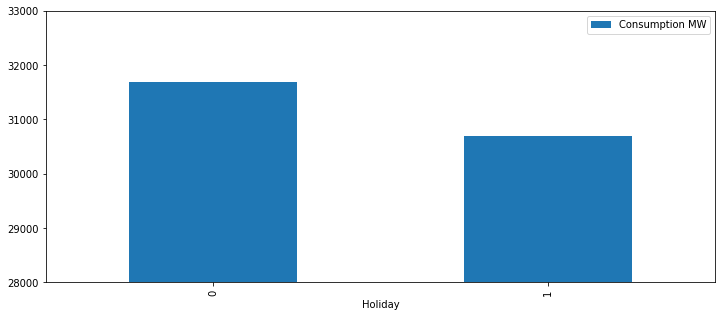

In [137]:
## Average Consumption (MW) by Holiday
#1 = Holiday, 0 = Not holiday
all_data.groupby('Holiday', as_index=False)['Consumption MW'].mean().plot(x = 'Holiday', y = 'Consumption MW', kind = 'bar')
plt.ylim(28000, 33000)

all_data.groupby('Holiday', as_index=False)['Consumption MW'].mean()

In [138]:
# Splitting Train and Test sets by using most recent 20% as test.

X = all_data.drop(columns = ['Consumption MW', 'Day']) # Separating features from labels and removing day (it doesn't help)
y = all_data['Consumption MW']

# Data scaling using MinMaxScaler
minmax = MinMaxScaler()
minmax.fit(X[['Year', 'Month', 'Hours', 'Weekday', 'Day of year']])
X[['Year', 'Month', 'Hours', 'Weekday', 'Day of year']] = minmax.transform(X[['Year', 'Month', 'Hours', 'Weekday', 'Day of year']])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False, stratify = None)
cv = TimeSeriesSplit(n_splits = 5) # Using TimeSeriesSplit for cross-validation

In [111]:
# Linear regression cross-validation
clf = LinearRegression(copy_X = True)
scores = np.sqrt(-1 * cross_val_score(clf, X_train, y_train, cv = cv, scoring = 'neg_mean_squared_error'))
print('Average Cross-Validation RMSE: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

# RMSE as a percentage of average consumption on train set
avg_consumption_train = y_train.mean()
rmse_to_avg_ratio = scores.mean()/avg_consumption_train
print('Average CV RMSE to Average Consumption Ratio: %0.2f %%' % (rmse_to_avg_ratio*100))

# R2 Score
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
r2 = metrics.r2_score(y_test, y_pred)
print('R2 Score: %0.2f' % r2)

# Explained Variance
explained_variance = metrics.explained_variance_score(y_test, y_pred)
print('Explained Variance: %0.2f' % explained_variance)

# RMSE
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('RMSE: %0.2f' % rmse)

Average Cross-Validation RMSE: 5555.66 (+/- 737.48)
Average CV RMSE to Average Consumption Ratio: 17.50 %
R2 Score: 0.14
Explained Variance: 0.26
RMSE: 5904.01


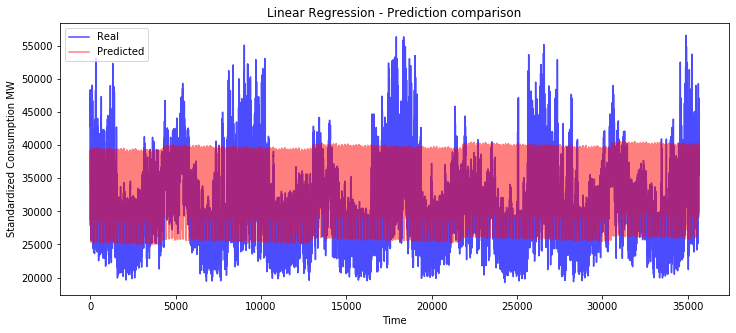

In [112]:
# Plotting the prediction and the real values for the test
plt.plot(y_test.to_numpy(), alpha=0.7, color='blue',label='Real')
plt.plot(y_pred, alpha=0.5, color='red',label='Predicted')
plt.title('Linear Regression - Prediction comparison')
plt.xlabel('Time')
plt.ylabel('Standardized Consumption MW')
plt.legend()
plt.show()

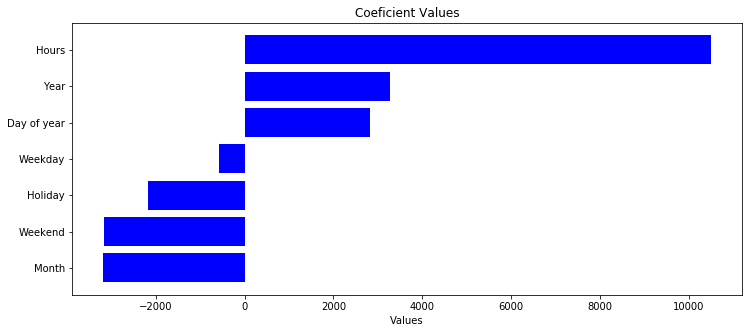

In [113]:
#Obteining coeficient values for linear regression
features = X_train.columns
coef = clf.coef_
indices = np.argsort(coef)

plt.title('Coeficient Values')
plt.barh(range(len(indices)), coef[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Values')
plt.show()

In [77]:
# Low R2 Score and Explained Variance indicate underfitting

# Polynomial Features + Linear Regression Pipeline
poly = PolynomialFeatures()
linreg = LinearRegression(copy_X = True)
pipe = Pipeline(steps = [('poly', poly), ('linreg', linreg)])

# Setting parameter limits for GridSearchCV
param_grid = {
    'poly__degree': [2, 3, 4, 5, 6, 7],
}

# GridSearch Cross Validation
search_poly = GridSearchCV(pipe, param_grid, scoring = 'neg_mean_squared_error', n_jobs = -1, cv = cv, verbose = 10)
search_poly.fit(X_train, y_train)
results_poly = pd.DataFrame(search_poly.cv_results_)
results_poly[['params', 'mean_test_score', 'rank_test_score']]

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  1.0min remaining:   36.2s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  3.6min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 17.4min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 23.2min finished


,params,mean_test_score,rank_test_score
0,{'poly__degree': 2},-3.259512e+07,1
1,{'poly__degree': 3},-1.642451e+18,3
2,{'poly__degree': 4},-1.496249e+17,2
3,{'poly__degree': 5},-1.831130e+18,4
4,{'poly__degree': 6},-1.184019e+21,6
5,{'poly__degree': 7},-3.952011e+20,5


In [78]:
# Scores for pipeline above
clf = search_poly.best_estimator_
print('Poly Degree: ', results_poly.loc[results_poly['rank_test_score'] == 1]['param_poly__degree'].values[0])
scores = np.sqrt(-1 * cross_val_score(clf, X_train, y_train, cv = cv, scoring = 'neg_mean_squared_error'))
print('Average Cross-Validation RMSE: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

# RMSE as a percentage of average consumption on train set
avg_consumption_train = y_train.mean()
rmse_to_avg_ratio = scores.mean()/avg_consumption_train
print('Average CV RMSE to Average Consumption Ratio: %0.2f %%' % (rmse_to_avg_ratio*100))

# R2 Score
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
r2 = metrics.r2_score(y_test, y_pred)
print('R2 Score: %0.2f' % r2)

# Explained Variance
explained_variance = metrics.explained_variance_score(y_test, y_pred)
print('Explained Variance: %0.2f' % explained_variance)

# RMSE
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('RMSE: %0.2f' % rmse)

Poly Degree:  2
Average Cross-Validation RMSE: 5681.65 (+/- 1161.78)
Average CV RMSE to Average Consumption Ratio: 17.90 %
R2 Score: 0.21
Explained Variance: 0.28
RMSE: 5679.30


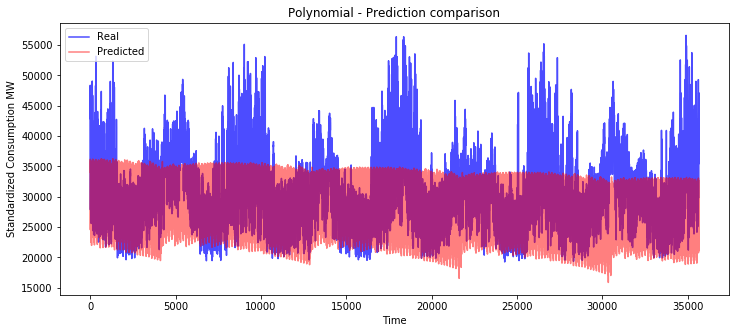

In [79]:
# Plotting the prediction and the real values for the test
plt.plot(y_test.to_numpy(), alpha=0.7, color='blue',label='Real')
plt.plot(y_pred, alpha=0.5, color='red',label='Predicted')
plt.title('Polynomial - Prediction comparison')
plt.xlabel('Time')
plt.ylabel('Standardized Consumption MW')
plt.legend()
plt.show()

In [80]:
# Using RandomForestRegressor

rf = RandomForestRegressor(n_jobs = -1)

# Setting parameter limits for GridSearchCV
param_grid = {
    'n_estimators': [10, 100, 200, 500, 1000],
    'min_samples_split': [2, 4]
}

# GridSearch Cross Validation
search_rf = GridSearchCV(rf, param_grid, scoring = 'neg_mean_squared_error', n_jobs = -1, cv = cv, verbose = 10)
search_rf.fit(X_train, y_train)
results_rf = pd.DataFrame(search_rf.cv_results_)
results_rf[['params', 'mean_test_score', 'rank_test_score']]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed: 11.2min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 13.9min remaining:   53.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 15.1min finished


,params,mean_test_score,rank_test_score
0,"{'min_samples_split': 2, 'n_estimators': 10}",-1.498046e+07,10
1,"{'min_samples_split': 2, 'n_estimators': 100}",-1.472883e+07,8
2,"{'min_samples_split': 2, 'n_estimators': 200}",-1.470843e+07,7
3,"{'min_samples_split': 2, 'n_estimators': 500}",-1.469281e+07,6
4,"{'min_samples_split': 2, 'n_estimators': 1000}",-1.468318e+07,5
5,"{'min_samples_split': 4, 'n_estimators': 10}",-1.497031e+07,9
6,"{'min_samples_split': 4, 'n_estimators': 100}",-1.463779e+07,4
7,"{'min_samples_split': 4, 'n_estimators': 200}",-1.461179e+07,3
8,"{'min_samples_split': 4, 'n_estimators': 500}",-1.461072e+07,2
9,"{'min_samples_split': 4, 'n_estimators': 1000}",-1.460038e+07,1


In [81]:
# Scores for RF Regressor
clf = search_rf.best_estimator_
print('Number of Estimators: ', results_rf.loc[results_rf['rank_test_score'] == 1]['param_n_estimators'].values[0])
print('Minimum Number of Samples to Split: ', results_rf.loc[results_rf['rank_test_score'] == 1]['param_min_samples_split'].values[0])
scores = np.sqrt(-1 * cross_val_score(clf, X_train, y_train, cv = cv, scoring = 'neg_mean_squared_error'))
print('Average Cross-Validation RMSE: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

# RMSE as a percentage of average consumption on train set
avg_consumption_train = y_train.mean()
rmse_to_avg_ratio = scores.mean()/avg_consumption_train
print('Average CV RMSE to Average Consumption Ratio: %0.2f %%' % (rmse_to_avg_ratio*100))

# R2 Score
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
r2 = metrics.r2_score(y_test, y_pred)
print('R2 Score: %0.2f' % r2)

# Explained Variance
explained_variance = metrics.explained_variance_score(y_test, y_pred)
print('Explained Variance: %0.2f' % explained_variance)

# RMSE
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('RMSE: %0.2f' % rmse)

Number of Estimators:  1000
Minimum Number of Samples to Split:  4
Average Cross-Validation RMSE: 3815.11 (+/- 466.85)
Average CV RMSE to Average Consumption Ratio: 12.02 %
R2 Score: 0.56
Explained Variance: 0.57
RMSE: 4246.59


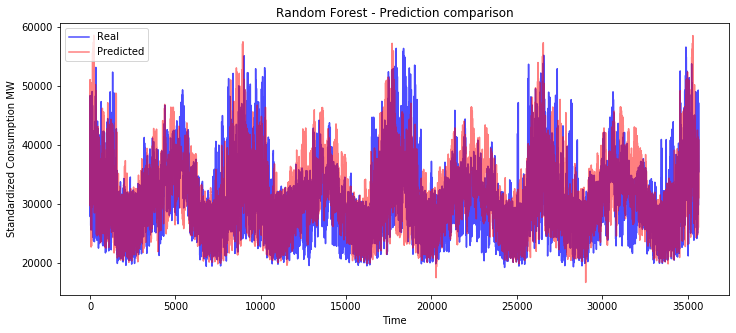

In [82]:
# Plotting the prediction and the real values for the test
plt.plot(y_test.to_numpy(), alpha=0.7, color='blue',label='Real')
plt.plot(y_pred, alpha=0.5, color='red',label='Predicted')
plt.title('Random Forest - Prediction comparison')
plt.xlabel('Time')
plt.ylabel('Standardized Consumption MW')
plt.legend()
plt.show()

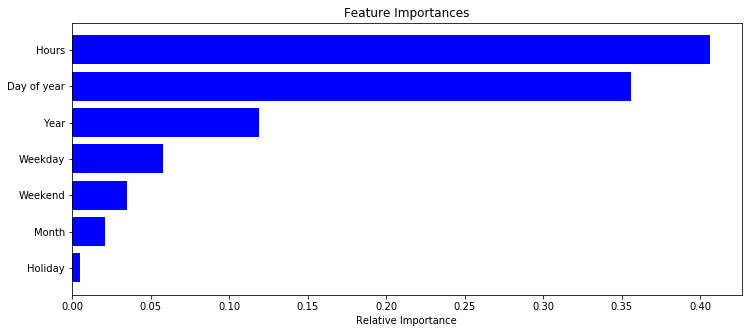

In [83]:
# Feature importance for the Random Forest

features = X_train.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [92]:
# AdaBoost with RandomForest
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1)
clf = AdaBoostRegressor(base_estimator = rf, n_estimators = 10, learning_rate = 0.1, loss = 'square')

# R2 Score
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
r2 = metrics.r2_score(y_test, y_pred)
print('R2 Score: %0.2f' % r2)

# Explained Variance
explained_variance = metrics.explained_variance_score(y_test, y_pred)
print('Explained Variance: %0.2f' % explained_variance)

# RMSE
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('RMSE: %0.2f' % rmse)

R2 Score: 0.57
Explained Variance: 0.58
RMSE: 4207.68


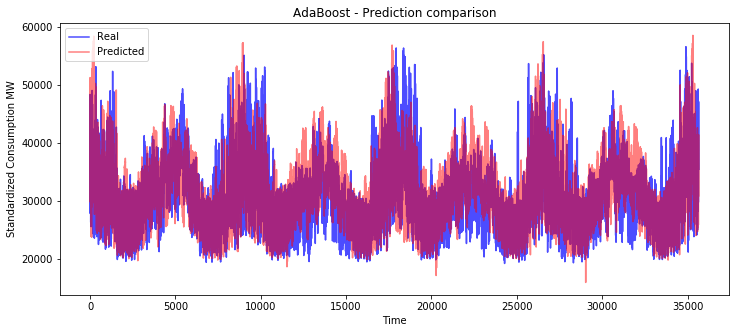

In [93]:
# Plotting the prediction and the real values for the test
plt.plot(y_test.to_numpy(), alpha=0.7, color='blue',label='Real')
plt.plot(y_pred, alpha=0.5, color='red',label='Predicted')
plt.title('AdaBoost - Prediction comparison')
plt.xlabel('Time')
plt.ylabel('Standardized Consumption MW')
plt.legend()
plt.show()

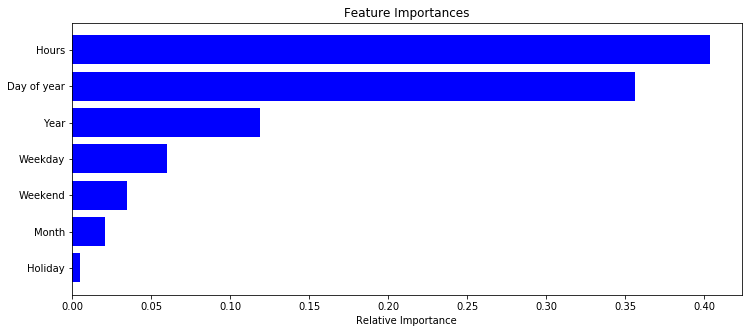

In [94]:
# Feature importance for the AdaBoost

features = X_train.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [84]:
# Boosting Avg with GradientBoosting
gboost = GradientBoostingRegressor(loss = 'ls', subsample = 1, init = None)

# Setting parameter limits for GridSearchCV
param_grid = {
    'learning_rate': [0.001, 0.1],
    'n_estimators': [50, 180, 200, 250]
}

# GridSearch Cross Validation
search_gb = GridSearchCV(gboost, param_grid, scoring = 'neg_mean_squared_error', n_jobs = -1, cv = cv, verbose = 10)
search_gb.fit(X_train, y_train)
results_gb = pd.DataFrame(search_gb.cv_results_)
results_gb[['params', 'mean_test_score', 'rank_test_score']]

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:   58.4s remaining:   19.4s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:  1.1min remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.3min finished


,params,mean_test_score,rank_test_score
0,"{'learning_rate': 0.001, 'n_estimators': 50}",-4.193008e+07,8
1,"{'learning_rate': 0.001, 'n_estimators': 180}",-3.833271e+07,7
2,"{'learning_rate': 0.001, 'n_estimators': 200}",-3.783558e+07,6
3,"{'learning_rate': 0.001, 'n_estimators': 250}",-3.664878e+07,5
4,"{'learning_rate': 0.1, 'n_estimators': 50}",-1.281545e+07,4
5,"{'learning_rate': 0.1, 'n_estimators': 180}",-1.125727e+07,2
6,"{'learning_rate': 0.1, 'n_estimators': 200}",-1.121436e+07,1
7,"{'learning_rate': 0.1, 'n_estimators': 250}",-1.128519e+07,3


In [85]:
# Scores for GB Regressor
clf = search_gb.best_estimator_
print('Number of Estimators: ', results_gb.loc[results_gb['rank_test_score'] == 1]['param_n_estimators'].values[0])
print('Learning Rate: ', results_gb.loc[results_gb['rank_test_score'] == 1]['param_learning_rate'].values[0])
scores = np.sqrt(-1 * cross_val_score(clf, X_train, y_train, cv = cv, scoring = 'neg_mean_squared_error'))
print('Average Cross-Validation RMSE: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

# RMSE as a percentage of average consumption on train set
avg_consumption_train = y_train.mean()
rmse_to_avg_ratio = scores.mean()/avg_consumption_train
print('Average CV RMSE to Average Consumption Ratio: %0.2f %%' % (rmse_to_avg_ratio*100))

# R2 Score
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
r2 = metrics.r2_score(y_test, y_pred)
print('R2 Score: %0.2f' % r2)

# Explained Variance
explained_variance = metrics.explained_variance_score(y_test, y_pred)
print('Explained Variance: %0.2f' % explained_variance)

# RMSE
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('RMSE: %0.2f' % rmse)

Number of Estimators:  200
Learning Rate:  0.1
Average Cross-Validation RMSE: 3345.68 (+/- 286.83)
Average CV RMSE to Average Consumption Ratio: 10.54 %
R2 Score: 0.66
Explained Variance: 0.67
RMSE: 3700.04


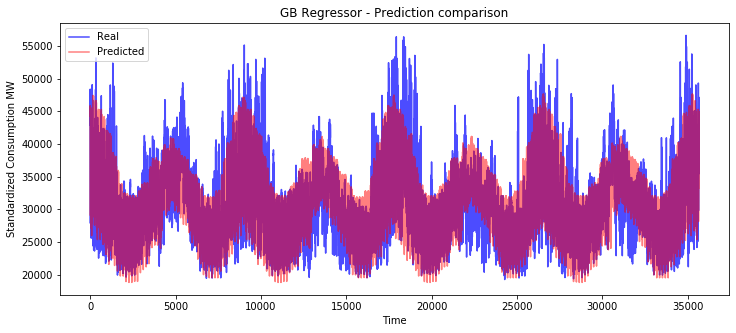

In [86]:
# Plotting the prediction and the real values for the test
plt.plot(y_test.to_numpy(), alpha=0.7, color='blue',label='Real')
plt.plot(y_pred, alpha=0.5, color='red',label='Predicted')
plt.title('GB Regressor - Prediction comparison')
plt.xlabel('Time')
plt.ylabel('Standardized Consumption MW')
plt.legend()
plt.show()

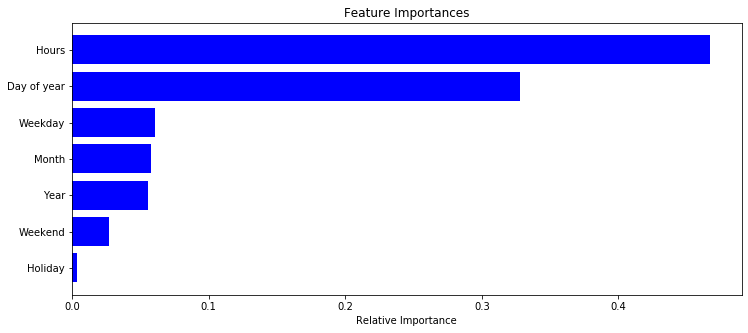

In [87]:
# Feature importance for the GB

features = X_train.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [220]:
## Data engineering for Recurrent Neural Network

data_RNN = RNN_data.copy() # Copy of the original data prepared for the RNN
data_RNN.columns = ['Datetime', 'Consumption MW']
data_RNN = data_RNN.set_index('Datetime')

split_len = int(0.8*data_RNN.shape[0])
data_RNN_train = data_RNN.iloc[0:split_len]

minmax = MinMaxScaler() # MinMax Standarization
data_RNN_train = pd.DataFrame(minmax.fit_transform(data_RNN_train.values))
data_RNN = pd.DataFrame(minmax.transform(data_RNN.values))

# Spliting 80% for train and 20% for test
train_x = []
train_y = []

seq_len = 24 # Sample sequence size entered into the network

for k in range(seq_len, len(data_RNN)):
    train_x.append(data_RNN.iloc[k - seq_len:k, 0])
    train_y.append(data_RNN.iloc[k, 0])

test_x = train_x[split_len:]             
test_y = train_y[split_len:]

train_x = train_x[:split_len]
train_y = train_y[:split_len]

test_x = np.array(test_x)
test_y = np.array(test_y)

train_x = np.array(train_x)
train_y = np.array(train_y)

train_x = np.reshape(train_x, (split_len, seq_len, 1))
test_x = np.reshape(test_x, (test_x.shape[0], seq_len, 1))

In [223]:
#Simple RNN model initialization (Keras)
model = Sequential()

model.add(SimpleRNN(50, activation="relu", return_sequences=True, input_shape=(seq_len, 1)))
model.add(SimpleRNN(50,activation="relu",return_sequences=True))
model.add(SimpleRNN(50,activation="relu",return_sequences=False))
model.add(Dense(1))

model.summary()

#sgd = SGD(lr=0.05, decay=1e-6, momentum=0.9)
model.compile(optimizer='adam', loss="MSE", metrics=['accuracy'])
model.fit(train_x, train_y, epochs=5, batch_size=512)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_13 (SimpleRNN)    (None, 24, 50)            2600      
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 24, 50)            5050      
_________________________________________________________________
simple_rnn_15 (SimpleRNN)    (None, 50)                5050      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 12,751
Trainable params: 12,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
142609/142609 [==============================] - 25s 176us/step - loss: 0.0038 - acc: 1.4024e-05
Epoch 2/5
142609/142609 [==============================] - 23s 159us/step - loss: 1.6449e-04 - acc: 1.4024e-05
Epoch 3/5
142609/142609 [===========================

In [224]:
# Prediction
pred = model.predict(test_x)

# R2 Score
r2 = metrics.r2_score(test_y, pred)
print('R2 Score: %0.5f' % r2)

# RMSE
rmse = np.sqrt(metrics.mean_squared_error(test_y, pred))
print('RMSE: %0.5f' % rmse)

R2 Score: 0.99586
RMSE: 0.00864


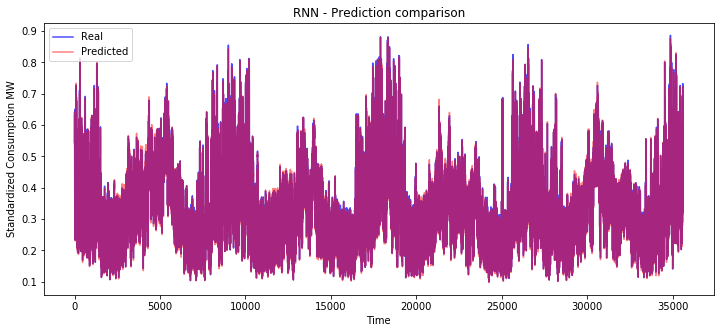

In [225]:
# Plotting the prediction and the real values for the test
plt.plot(test_y, alpha=0.7, color='blue',label='Real')
plt.plot(pred, alpha=0.5, color='red',label='Predicted')
plt.title('RNN - Prediction comparison')
plt.xlabel('Time')
plt.ylabel('Standardized Consumption MW')
plt.legend()
plt.show()